In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber

In [18]:
CSV_PATH = 'data/data_for_modeling.csv'
N_STEPS = 60    # look-back window (days)
HORIZON = 7     # forecast horizon (sum next 7 days)
EPOCHS = 100
BATCH = 32

# ─────────────────────────────────────────────────────────────────────────────────
# 2) LOAD & AGGREGATE per ID & DATE
df = pd.read_csv(CSV_PATH, parse_dates=['date'])
daily = (
    df
    .groupby(['unique_id','date'], as_index=False)['units']
    .sum()
    .sort_values(['unique_id','date']))

1) Re-index each series on a daily calendar

In [19]:
def reindex_gid(grp):
    uid = grp.name
    # full span from first to last date for this series
    idx = pd.date_range(grp['date'].min(), grp['date'].max(), freq='D')
    # reindex, filling missing days with zero
    out = (
        grp
        .set_index('date')
        .reindex(idx, fill_value=0)
        .rename_axis('date')
        .reset_index()
    )
    out['unique_id'] = uid
    return out

daily = (
    daily
    .groupby('unique_id', sort=False)
    .apply(reindex_gid, include_groups=False)
    .reset_index(drop=True)
)


2) Build sequences and capture the target-date for splitting later

In [20]:
def create_sequences_with_dates(series, targets, dates, n_steps):
    Xs, ys, ds = [], [], []
    for i in range(len(series) - n_steps + 1):
        Xs.append(series[i : i + n_steps])
        ys.append(targets[i + n_steps - 1])
        ds.append(dates[i + n_steps - 1])   # end-of-window
    return np.array(Xs), np.array(ys), np.array(ds)

records = []
for uid, grp in daily.groupby('unique_id', sort=False):
    # rolling 7-day sum target, aligned at end of window
    grp = grp.copy()
    grp['target'] = (
        grp['units']
           .rolling(window=HORIZON)
           .sum()
           .shift(-HORIZON + 1)
    )
    grp = grp.dropna(subset=['target']).reset_index(drop=True)

    Xs, ys, ds = create_sequences_with_dates(
        grp['units'].values,
        grp['target'].values,
        grp['date'].values,
        N_STEPS
    )

    for x,y,d in zip(Xs, ys, ds):
        records.append({'unique_id':uid, 'X':x, 'y':y, 'date':d})

seq_df = pd.DataFrame(records)


3) Fixed-horizon train/val/test by calendar date

In [21]:
# define your hold-out lengths (in days)
VAL_DAYS  = 30
TEST_DAYS = 14

def split_fixed(df, val_days, test_days):
    max_date   = df['date'].max()
    test_start = max_date - pd.Timedelta(days=test_days)
    val_start  = test_start - pd.Timedelta(days=val_days)

    train = df[df['date'] <  val_start]
    val   = df[(df['date'] >= val_start) & (df['date'] < test_start)]
    test  = df[df['date'] >= test_start]
    return train, val, test

train_df, val_df, test_df = split_fixed(seq_df, VAL_DAYS, TEST_DAYS)

# stack back into arrays
X_train = np.stack(train_df['X'].values)  # shape=(n_train, N_STEPS)
y_train = train_df['y'].values
X_val   = np.stack(val_df['X'].values)
y_val   = val_df['y'].values
X_test  = np.stack(test_df['X'].values)
y_test  = test_df['y'].values

# reshape for LSTM
X_train = X_train.reshape(-1, N_STEPS, 1)
X_val   = X_val.reshape(-1, N_STEPS, 1)
X_test  = X_test.reshape(-1, N_STEPS, 1)


4) Per-series target scaling

In [22]:
# fit one MinMaxScaler per unique_id on its *training* targets
scalers_y = {}
y_train_scaled = np.zeros_like(y_train, dtype=float)

for uid in train_df['unique_id'].unique():
    mask = train_df['unique_id'] == uid
    s = MinMaxScaler()
    y_train_scaled[mask] = s.fit_transform(y_train[mask].reshape(-1,1)).flatten()
    scalers_y[uid] = s

# transform val & test targets with the *same* per-series scalers
def apply_scaling(y_raw, df_meta, scalers):
    y_scaled = np.zeros_like(y_raw, dtype=float)
    for uid, s in scalers.items():
        mask = df_meta['unique_id'] == uid
        if mask.any():
            y_scaled[mask] = s.transform(y_raw[mask].reshape(-1,1)).flatten()
    return y_scaled

y_val_scaled  = apply_scaling(y_val,  val_df, scalers_y)
y_test_scaled = apply_scaling(y_test, test_df, scalers_y)


5) More robust loss & dropout, plus RMSE reporting

In [23]:
# rebuild & compile
model = Sequential([
    Input((N_STEPS,1)),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# train
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
7334/7334 ━━━━━━━━━━━━━━━━━━━━ 274s 37ms/step - loss: 0.0142 - mae: 0.1187 - val_loss: 0.0098 - val_mae: 0.0816
Epoch 2/100
7334/7334 ━━━━━━━━━━━━━━━━━━━━ 272s 37ms/step - loss: 0.0119 - mae: 0.1045 - val_loss: 0.0091 - val_mae: 0.0857
Epoch 3/100
7334/7334 ━━━━━━━━━━━━━━━━━━━━ 272s 37ms/step - loss: 0.0116 - mae: 0.1020 - val_loss: 0.0093 - val_mae: 0.0836
Epoch 4/100
7334/7334 ━━━━━━━━━━━━━━━━━━━━ 273s 37ms/step - loss: 0.0113 - mae: 0.1003 - val_loss: 0.0092 - val_mae: 0.0841
Epoch 5/100
7334/7334 ━━━━━━━━━━━━━━━━━━━━ 273s 37ms/step - loss: 0.0113 - mae: 0.1000 - val_loss: 0.0098 - val_mae: 0.0848
Epoch 6/100
7334/7334 ━━━━━━━━━━━━━━━━━━━━ 273s 37ms/step - loss: 0.0111 - mae: 0.0988 - val_loss: 0.0090 - val_mae: 0.0826
Epoch 7/100
7334/7334 ━━━━━━━━━━━━━━━━━━━━ 274s 37ms/step - loss: 0.0109 - mae: 0.0980 - val_loss: 0.0093 - val_mae: 0.0842
Epoch 8/100
7334/7334 ━━━━━━━━━━━━━━━━━━━━ 274s 37ms/step - loss: 0.0110 - mae: 0.0980 - val_loss: 0.0087 - val_mae: 0.0794
Epoch 9/

In [ ]:
model.save('lstm_1_week.h5')

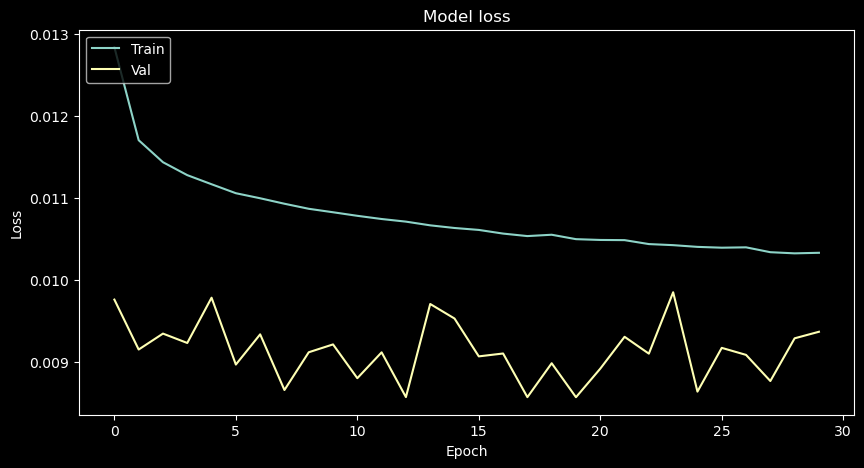

In [25]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

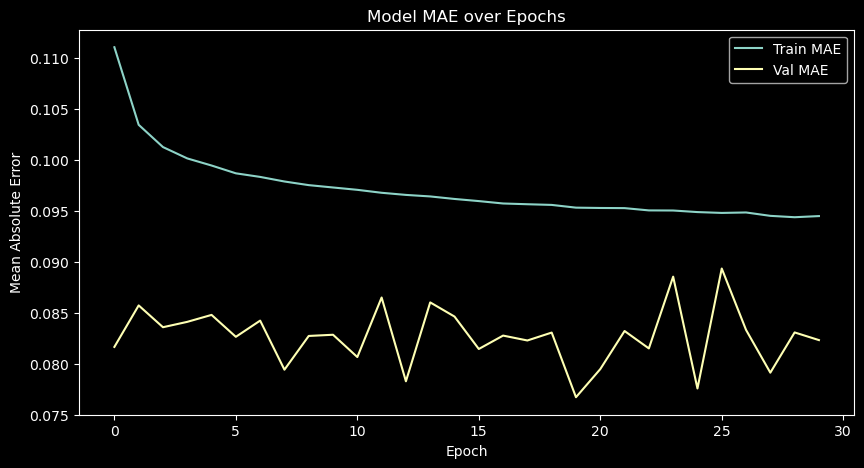

In [26]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history.history['mae'],     label='Train MAE')
ax.plot(history.history['val_mae'], label='Val MAE')

ax.set_title('Model MAE over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.legend(loc='upper right')

plt.show()

In [27]:
y_val_pred_scaled = model.predict(X_val).flatten()
y_val_pred = np.zeros_like(y_val)
for uid, s in scalers_y.items():
    mask = (val_df['unique_id'] == uid).values
    y_val_pred[mask] = s.inverse_transform(
        y_val_pred_scaled[mask].reshape(-1,1)
    ).flatten()

# 2) Grab the true values
y_val_true = y_val.copy()

# 3) Compute RMSE
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print(f"Validation RMSE (units): {val_rmse:.2f}")

# 4) (Optional) Quickly inspect a few true vs. pred
val_inspect = pd.DataFrame({
    'unique_id': val_df['unique_id'].values,
    'date'     : val_df['date'].dt.date,
    'y_true'   : y_val_true,
    'y_pred'   : y_val_pred
})
print("\nSample of true vs. predicted on validation:")
print(val_inspect.head(10))

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Validation RMSE (units): 150.81

Sample of true vs. predicted on validation:
    unique_id        date  y_true    y_pred
925     10_21  2014-09-11     0.0 -0.060272
926     10_21  2014-09-12     0.0 -0.060272
927     10_21  2014-09-13     0.0 -0.060272
928     10_21  2014-09-14     0.0 -0.060272
929     10_21  2014-09-15     0.0 -0.060272
930     10_21  2014-09-16     0.0 -0.060272
931     10_21  2014-09-17     0.0 -0.060272
932     10_21  2014-09-18     0.0 -0.060272
933     10_21  2014-09-19     0.0 -0.060272
934     10_21  2014-09-20     0.0 -0.060272


In [28]:
# same for test
y_test_pred_scaled = model.predict(X_test).flatten()
y_test_pred = np.zeros_like(y_test)
for uid, s in scalers_y.items():
    mask = (test_df['unique_id']==uid).values
    y_test_pred[mask] = s.inverse_transform(y_test_pred_scaled[mask].reshape(-1,1)).flatten()

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE (units): {test_rmse:.2f}")

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test RMSE (units): 165.21


  unique_id       date  y_true    y_pred
0     10_21 2014-10-11     0.0 -0.060272
1     10_21 2014-10-12     0.0 -0.060272
2     10_21 2014-10-13     0.0 -0.060272
3     10_21 2014-10-14     0.0 -0.060272
4     10_21 2014-10-15     0.0 -0.060272
5     10_21 2014-10-16     0.0 -0.060272
6     10_21 2014-10-17     0.0 -0.060272
7     10_21 2014-10-18     0.0 -0.060272
8     10_21 2014-10-19     0.0 -0.060272
9     10_21 2014-10-20     0.0 -0.060272


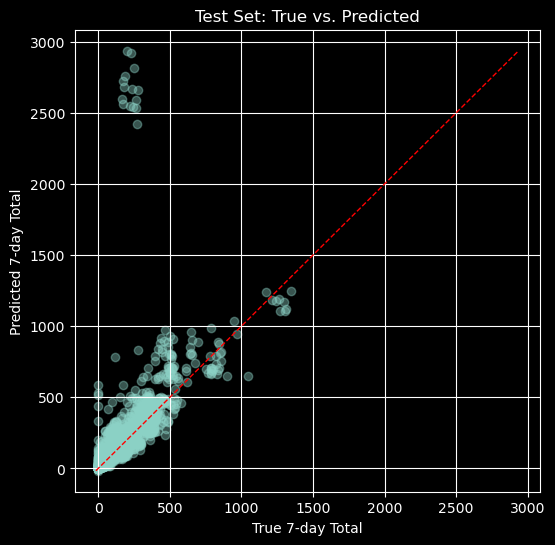

In [29]:
test_results = pd.DataFrame({
    'unique_id': test_df['unique_id'].values,
    'date': test_df['date'].values,
    'y_true': y_test,
    'y_pred': y_test_pred
})

# 2) Print a quick sample
print(test_results.head(10))

# 3) Overall scatter: true vs. predicted
plt.style.use('dark_background')
plt.figure(figsize=(6,6))
plt.scatter(test_results['y_true'], test_results['y_pred'], alpha=0.4)
lims = [
    min(test_results['y_true'].min(), test_results['y_pred'].min()),
    max(test_results['y_true'].max(), test_results['y_pred'].max())
]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlabel('True 7-day Total')
plt.ylabel('Predicted 7-day Total')
plt.title('Test Set: True vs. Predicted')
plt.grid(True)
plt.show()

In [30]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(test_results['y_true'], test_results['y_pred']))
print(f"RMSE: {rmse:.2f}")

# MAE
mae = mean_absolute_error(test_results['y_true'], test_results['y_pred'])
print(f"MAE: {mae:.2f}")

# MAPE
mape = mean_absolute_percentage_error(test_results['y_true'], test_results['y_pred']) * 100
print(f"MAPE: {mape:.2f}%")

# SMAPE
smape = np.mean(2 * np.abs(test_results['y_pred'] - test_results['y_true']) / (np.abs(test_results['y_true']) + np.abs(test_results['y_pred']))) * 100
print(f"SMAPE: {smape:.2f}%")

# R²
r2 = r2_score(test_results['y_true'], test_results['y_pred'])
print(f"R²: {r2:.3f}")


RMSE: 165.21
MAE: 35.34
MAPE: 698050494156822144.00%
SMAPE: 122.43%
R²: -0.213
